# Predict the growth of people infected with coronavirus
## Using TensorFlow with Long Short-Term Memory (LSTM)

# Import the libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from pandas_profiling import ProfileReport

# Data Preparation

In [2]:
patient_df = pd.read_csv("https://raw.githubusercontent.com/MohammadFebriyanto/Bangkit_Project/master/DATA/patient.csv")
time_df = pd.read_csv("https://raw.githubusercontent.com/MohammadFebriyanto/Bangkit_Project/master/DATA/time.csv")
route_df = pd.read_csv("https://raw.githubusercontent.com/MohammadFebriyanto/Bangkit_Project/master/DATA/route.csv")

In [3]:
time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 24 columns):
date                 52 non-null object
time                 52 non-null int64
test                 52 non-null int64
negative             52 non-null int64
confirmed            52 non-null int64
released             52 non-null int64
deceased             52 non-null int64
Seoul                52 non-null int64
Busan                52 non-null int64
Daegu                52 non-null int64
Incheon              52 non-null int64
Gwangju              52 non-null int64
Daejeon              52 non-null int64
Ulsan                52 non-null int64
Sejong               52 non-null int64
Gyeonggi-do          52 non-null int64
Gangwon-do           52 non-null int64
Chungcheongbuk-do    52 non-null int64
Chungcheongnam-do    52 non-null int64
Jeollabuk-do         52 non-null int64
Jeollanam-do         52 non-null int64
Gyeongsangbuk-do     52 non-null int64
Gyeongsangnam-do     52 non-null int64

In [4]:
route_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 7 columns):
patient_id    212 non-null int64
date          212 non-null object
province      212 non-null object
city          212 non-null object
visit         212 non-null object
latitude      212 non-null float64
longitude     212 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 11.7+ KB


In [5]:
patient_df.head()

,patient_id,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
0,1,female,1984.0,China,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released
1,2,male,1964.0,Korea,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released
2,3,male,1966.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released
3,4,male,1964.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released
4,5,male,1987.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released


In [6]:
patient_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7754 entries, 0 to 7753
Data columns (total 15 columns):
patient_id          7754 non-null int64
sex                 678 non-null object
birth_year          665 non-null float64
country             7754 non-null object
region              436 non-null object
disease             28 non-null float64
group               86 non-null object
infection_reason    154 non-null object
infection_order     36 non-null float64
infected_by         70 non-null float64
contact_number      53 non-null float64
confirmed_date      7754 non-null object
released_date       55 non-null object
deceased_date       36 non-null object
state               7754 non-null object
dtypes: float64(5), int64(1), object(9)
memory usage: 908.8+ KB


In [7]:
patient_df.columns

Index(['patient_id', 'sex', 'birth_year', 'country', 'region', 'disease',
       'group', 'infection_reason', 'infection_order', 'infected_by',
       'contact_number', 'confirmed_date', 'released_date', 'deceased_date',
       'state'],
      dtype='object')

# Data profiling

Using Google Colab
    
    #Install library
    !pip install -U pandas_profiling
    
    #Library
    import pandas_profiling
    from pandas_profiling import ProfileReport
    
    #Define
    name_profile = name_dateset.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)

In [8]:
profile_patient = ProfileReport(patient_df) 
profile_time = ProfileReport(time_df) 
profile_route = ProfileReport(route_df)

In [9]:
profile_patient.to_file(output_file="DATA PROFILING/profile_patient.html")
profile_time.to_file(output_file="DATA PROFILING/profile_time.html")
profile_route.to_file(output_file="DATA PROFILING/profile_route.html")

# Feature Engineering

In [10]:
#Numerical Imputation
patient_df["birth_year"] = patient_df.birth_year.fillna(0.0).astype(int)
patient_df["birth_year"] = patient_df["birth_year"].map(lambda val: val if val > 0 else np.nan)

In [11]:
patient_df.confirmed_date = pd.to_datetime(patient_df.confirmed_date)

In [12]:
count_id = patient_df.groupby(patient_df.confirmed_date).patient_id.count()

In [13]:
accumulated_count = count_id.cumsum()

In [14]:
#Extracting date
import datetime

In [15]:
now = datetime.datetime.now()
now.year

2020

In [16]:
patient_df["age"] = now.year - patient_df["birth_year"]

In [17]:
patient_df["age"].head()

0    36.0
1    56.0
2    54.0
3    56.0
4    33.0
Name: age, dtype: float64

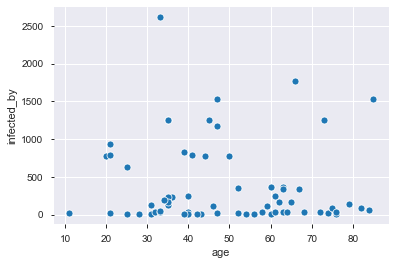

In [18]:
sns.scatterplot(x='age', y='infected_by', data=patient_df)

In [19]:
def group_age(age):
    if age >= 0:
        if age % 10 != 0:
            lower = int(math.floor(age/10.0))*10
            upper = int(math.ceil(age/10.0))*10-1
            return f"{lower}-{upper}"
        else:
            lower = int(age)
            upper = int(age+9)
            return f"{lower}-{upper}"
        return np.nan

In [20]:
group_age(15)

'10-19'

In [21]:
patient_df["age_range"] = patient_df["age"].apply(group_age)

In [22]:
age_order=patient_df['age_range'].unique()

In [23]:
age_order

array(['30-39', '50-59', '20-29', '60-69', '40-49', '70-79', '80-89',
       '10-19', None, '0-9', '90-99'], dtype=object)

In [24]:
age_order = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']

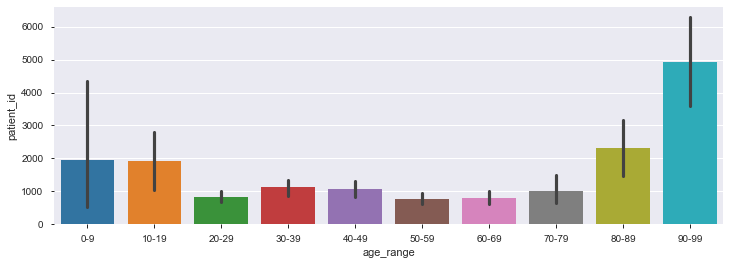

In [25]:
plt.figure(figsize=(12,4))
sns.barplot(x='age_range',y='patient_id',data=patient_df, order=age_order)

In [26]:
patient_df['sex']

0       female
1         male
2         male
3         male
4         male
         ...  
7749       NaN
7750       NaN
7751       NaN
7752       NaN
7753       NaN
Name: sex, Length: 7754, dtype: object

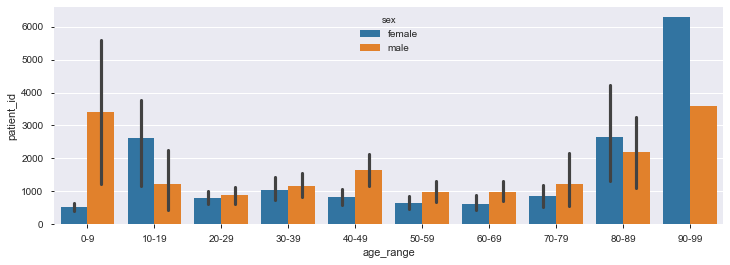

In [27]:
plt.figure(figsize=(12,4))
sns.barplot(x='age_range',y='patient_id',data=patient_df, hue='sex', order=age_order)

In [28]:
time_df.head()

,date,time,test,negative,confirmed,released,deceased,Seoul,Busan,Daegu,...,Sejong,Gyeonggi-do,Gangwon-do,Chungcheongbuk-do,Chungcheongnam-do,Jeollabuk-do,Jeollanam-do,Gyeongsangbuk-do,Gyeongsangnam-do,Jeju-do
0,2020-01-20,16,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-21,16,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-22,16,4,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-23,16,22,21,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-24,16,27,25,2,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [29]:
time_df['confirmed']

0        1
1        1
2        1
3        1
4        2
5        2
6        3
7        4
8        4
9        4
10       6
11      11
12      12
13      15
14      15
15      16
16      18
17      23
18      24
19      24
20      27
21      27
22      28
23      28
24      28
25      28
26      28
27      29
28      30
29      31
30      51
31     104
32     204
33     433
34     602
35     833
36     977
37    1261
38    1766
39    2337
40    3150
41    3736
42    4212
43    4812
44    5328
45    5766
46    6284
47    6767
48    7134
49    7382
50    7513
51    7755
Name: confirmed, dtype: int64

In [30]:
patient = patient_df

In [31]:
column_date = ["confirmed_date","released_date","deceased_date"]

In [32]:
for col in column_date:
    patient[col] = pd.to_datetime(patient[col])

In [33]:
patient["released_date"]

0      2020-02-06
1      2020-02-05
2      2020-02-12
3      2020-02-09
4      2020-03-02
          ...    
7749          NaT
7750          NaT
7751          NaT
7752          NaT
7753          NaT
Name: released_date, Length: 7754, dtype: datetime64[ns]

In [34]:
patient.head()

,patient_id,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state,age,age_range
0,1,female,1984.0,China,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaT,released,36.0,30-39
1,2,male,1964.0,Korea,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaT,released,56.0,50-59
2,3,male,1966.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaT,released,54.0,50-59
3,4,male,1964.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaT,released,56.0,50-59
4,5,male,1987.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaT,released,33.0,30-39


In [35]:
patient["time_to_release"] = patient["released_date"] - patient["confirmed_date"]
patient["time_to_death"] = patient["deceased_date"] - patient["confirmed_date"]
patient["duration"] = patient[["time_to_release","time_to_death"]].min(axis=1)
patient["duration_days"] = patient["duration"].dt.days

In [36]:
patient["age_range"].unique()

array(['30-39', '50-59', '20-29', '60-69', '40-49', '70-79', '80-89',
       '10-19', None, '0-9', '90-99'], dtype=object)

In [37]:
range_of_age = sorted(set([ar for ar in patient["age_range"] if ar != None]))

In [38]:
patient['state_by_gender'] = patient['state'] + '_' + patient['sex']

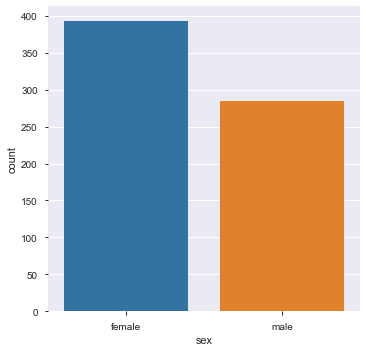

In [39]:
sns.catplot(x='sex', kind='count', data=patient_df);

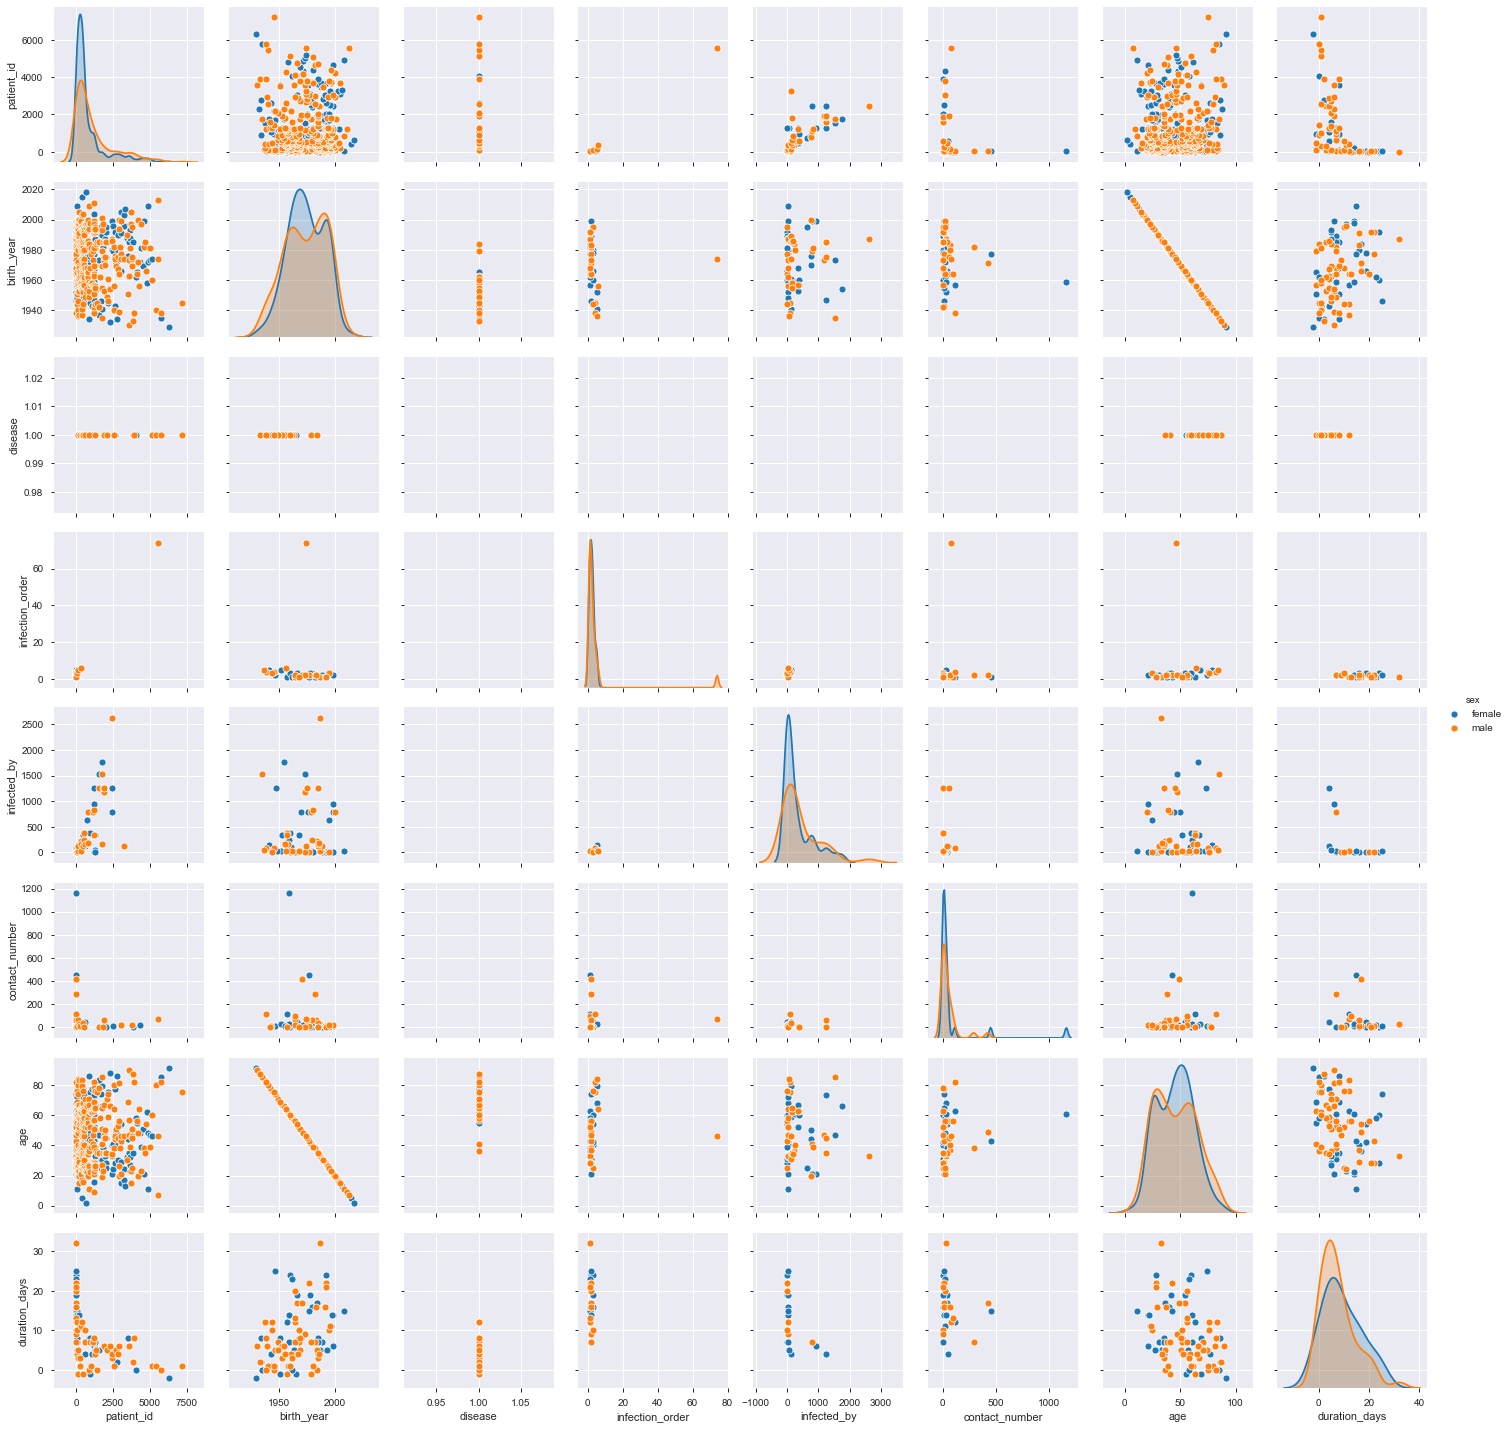

In [40]:
sns.pairplot(patient_df, hue='sex');

In [41]:
patient_df['infection_reason'].unique()

array(['visit to Wuhan', 'contact with patient',
       'contact with patient in Japan', 'residence in Wuhan',
       'visit to Thailand', 'contact with patient in Singapore',
       'visit to China', nan, 'visit to Daegu', 'pilgrimage to Israel',
       'contact with patient in Daegu', 'visit to Vietnam',
       'visit to Japan', 'visit to Italy', 'visit to ooo'], dtype=object)

In [42]:
infection_reason = ['visit to Wuhan', 'contact with patient',
       'contact with patient in Japan', 'residence in Wuhan',
       'visit to Thailand', 'contact with patient in Singapore',
       'visit to China', 'visit to Daegu', 'pilgrimage to Israel',
       'contact with patient in Daegu', 'visit to Vietnam',
       'visit to Japan', 'visit to Italy', 'visit to ooo']

In [43]:
numerical_infection = []

for i in infection_reason:
    numeric = patient_df[patient_df['infection_reason'] == i]['patient_id'].count()
    numerical_infection.append(numeric)

In [44]:
numerical_infection

[8, 76, 1, 2, 2, 2, 2, 50, 6, 1, 1, 1, 1, 1]

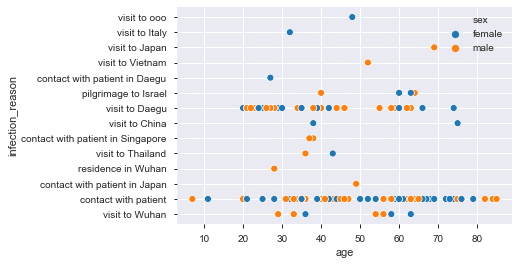

In [45]:
sns.scatterplot(x='age', y='infection_reason', hue='sex', data=patient_df)

<BarContainer object of 14 artists>

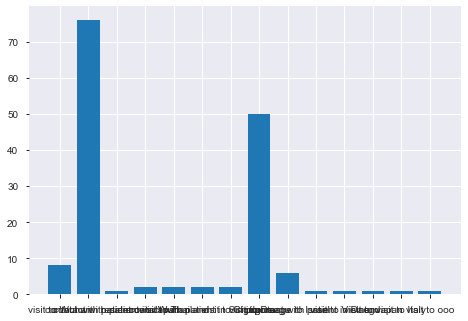

In [46]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(patient_df['infection_reason'].dropna().unique(), numerical_infection)

In [47]:
released = patient_df[patient_df.state == 'released']
isolated = patient_df[patient_df.state == 'isolated']
dead = patient_df[patient_df.state == 'deceased']

# Data Profiling 

In [48]:
profile_released = ProfileReport(released)
profile_dead = ProfileReport(dead)

In [49]:
profile_dead.to_file(output_file="DATA PROFILING/profile_dead.html")
profile_released.to_file(output_file="DATA PROFILING/profile_released.html")

# Confirmed Cases

Text(0.5, 1.0, 'Confirmed Case')

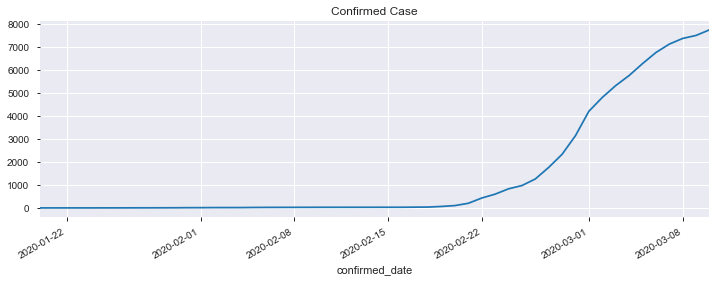

In [50]:
plt.figure(figsize=(12,4))
accumulated_count.plot()
plt.title('Confirmed Case')

In [51]:
route_df.head()

,patient_id,date,province,city,visit,latitude,longitude
0,1,2020-01-19,Incheon,Jung-gu,airport,37.460459,126.440680
1,1,2020-01-20,Incheon,Seo-gu,hospital_isolated,37.478832,126.668558
2,2,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.562143,126.801884
3,2,2020-01-23,Seoul,Jung-gu,hospital_isolated,37.567454,127.005627
4,3,2020-01-20,Incheon,Jung-gu,airport,37.460459,126.440680


# Data Prep for LSTM

In [52]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

In [53]:
data = count_id.resample('D').first().fillna(0).cumsum()
data = data[10:]

In [54]:
data

confirmed_date
2020-01-30       7.0
2020-01-31      11.0
2020-02-01      12.0
2020-02-02      15.0
2020-02-03      15.0
2020-02-04      16.0
2020-02-05      21.0
2020-02-06      24.0
2020-02-07      24.0
2020-02-08      24.0
2020-02-09      27.0
2020-02-10      28.0
2020-02-11      28.0
2020-02-12      28.0
2020-02-13      28.0
2020-02-14      28.0
2020-02-15      28.0
2020-02-16      30.0
2020-02-17      30.0
2020-02-18      38.0
2020-02-19      65.0
2020-02-20     103.0
2020-02-21     203.0
2020-02-22     432.0
2020-02-23     601.0
2020-02-24     832.0
2020-02-25     975.0
2020-02-26    1262.0
2020-02-27    1766.0
2020-02-28    2337.0
2020-02-29    3149.0
2020-03-01    4211.0
2020-03-02    4811.0
2020-03-03    5327.0
2020-03-04    5765.0
2020-03-05    6283.0
2020-03-06    6766.0
2020-03-07    7133.0
2020-03-08    7381.0
2020-03-09    7512.0
2020-03-10    7754.0
Freq: D, Name: patient_id, dtype: float64

In [55]:
x = np.arange(len(data)).reshape(-1,1)
y = data.values

In [56]:
y.shape

(41,)

In [57]:
x.shape

(41, 1)

# Using TensorFlow with Long Short-Term Memory (LSTM) 




In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [59]:
df = pd.DataFrame(data)
df.columns = ['Number of Confirmed']
df.head()

,Number of Confirmed
confirmed_date,
2020-01-30,7.0
2020-01-31,11.0
2020-02-01,12.0
2020-02-02,15.0
2020-02-03,15.0


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2020-01-30 to 2020-03-10
Freq: D
Data columns (total 1 columns):
Number of Confirmed    41 non-null float64
dtypes: float64(1)
memory usage: 656.0 bytes


In [61]:
data = np.array(df).reshape(-1,1)

In [62]:
train_data = df[:len(df)-7]
test_data = df[len(df)-7:]

In [63]:
scaler = MinMaxScaler()

In [64]:
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [65]:
n_input = 5
n_features = 1

In [66]:
generator = TimeseriesGenerator(train_data, train_data, length=n_input, batch_size=1)

In [67]:
model = Sequential()

In [68]:
model.add(LSTM(units = 50, return_sequences = True, input_shape=(n_input,n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(generator, epochs=30)

W0405 20:51:32.729334 23532 deprecation.py:506] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/30


W0405 20:51:35.060364 23532 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


29/29 [==============================] - 10s 346ms/step - loss: 0.0875
Epoch 2/30
29/29 [==============================] - 1s 28ms/step - loss: 0.0696
Epoch 3/30
29/29 [==============================] - 1s 24ms/step - loss: 0.0369
Epoch 4/30
29/29 [==============================] - 1s 24ms/step - loss: 0.0086
Epoch 5/30
29/29 [==============================] - 1s 24ms/step - loss: 0.0390
Epoch 6/30
29/29 [==============================] - 1s 23ms/step - loss: 0.0086
Epoch 7/30
29/29 [==============================] - 1s 23ms/step - loss: 0.0155
Epoch 8/30
29/29 [==============================] - 1s 29ms/step - loss: 0.0095
Epoch 9/30
29/29 [==============================] - 1s 27ms/step - loss: 0.0082
Epoch 10/30
29/29 [==============================] - 1s 27ms/step - loss: 0.0143
Epoch 11/30
29/29 [==============================] - 1s 25ms/step - loss: 0.0052
Epoch 12/30
29/29 [==============================] - 1s 29ms/step - loss: 0.0173
Epoch 13/30
29/29 [===========================

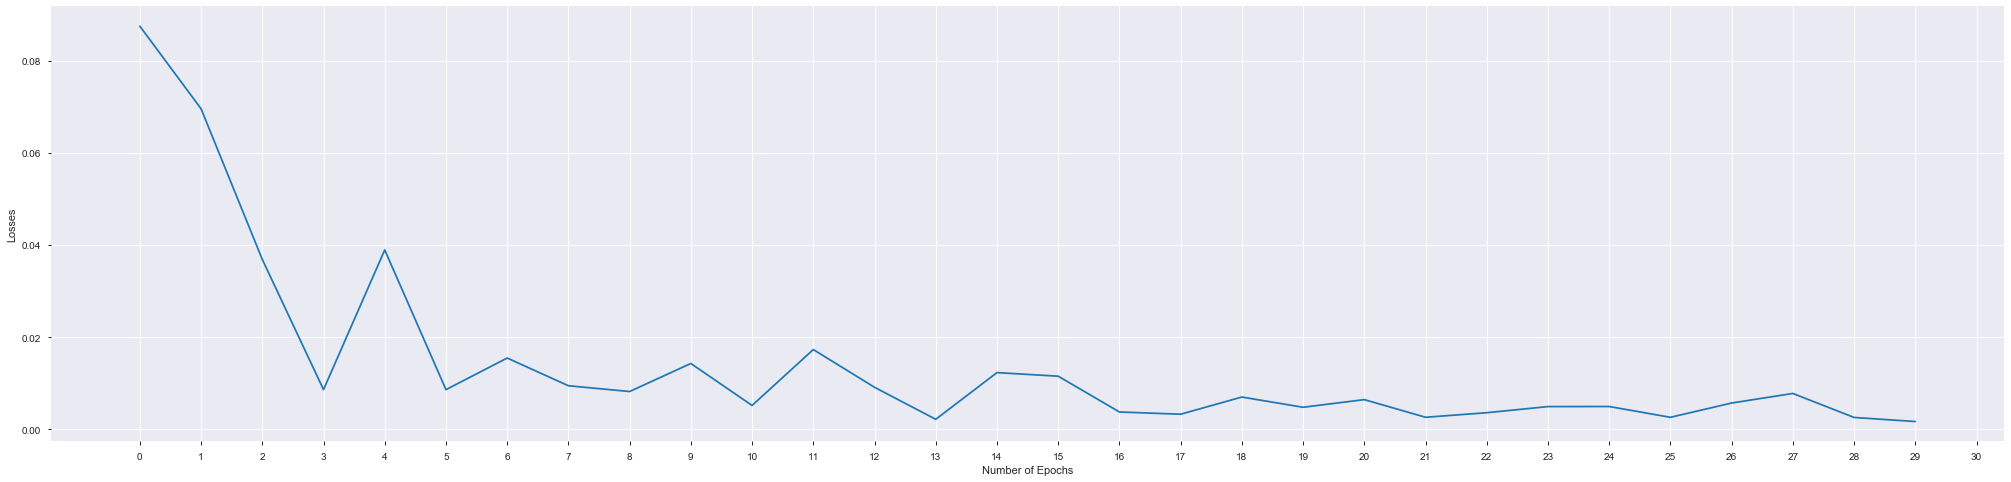

In [69]:
losses = model.history.history['loss']
plt.figure(figsize = (35,8))
plt.xlabel('Number of Epochs')
plt.ylabel('Losses')
plt.xticks(np.arange(0,150,1))
plt.plot(range(len(losses)), losses)

In [70]:
prediction_scaled = []

In [71]:
batch = train_data[-n_input:]
current_batch = batch.reshape((1,n_input,n_features))

In [72]:
for i in range(len(test_data)):
    pred = model.predict(current_batch)[0]
    prediction_scaled.append(pred)
    current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)

In [73]:
prediction = pd.DataFrame(scaler.inverse_transform(prediction_scaled))

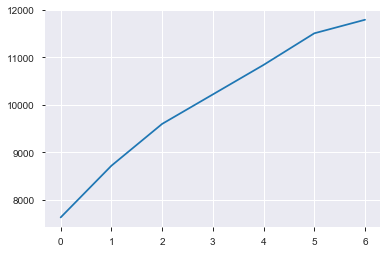

In [74]:
plt.plot(prediction)

Predicted how many people will be infected by the coronavirus in the next seven days. 
    
Entered a week because the more days put in, the more inaccurate the prediction we get.

## Prediction for country: Indonesia

In [75]:
data_Ina = pd.read_csv("https://raw.githubusercontent.com/MohammadFebriyanto/Bangkit_Project/master/DATA/TotalCaseConvir_INA.csv", delimiter=';')

In [76]:
data_Ina.tail(8) #Value zero means there is value that we want to predict

,Date,case
34,2020-04-05,2273
35,2020-04-06,0
36,2020-04-07,0
37,2020-04-08,0
38,2020-04-09,0
39,2020-04-10,0
40,2020-04-11,0
41,2020-04-12,0


In [77]:
data = data_Ina.drop('Date', axis=1)

In [78]:
data = np.array(data).reshape(-1,1)

In [79]:
train_data = data[:len(data)-7]
test_data = data[len(data)-7:]

scaler = MinMaxScaler()

scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

n_input = 5
n_features = 1

generator = TimeseriesGenerator(train_data, train_data, length=n_input, batch_size=1)

Epoch 1/30
30/30 [==============================] - 11s 350ms/step - loss: 0.1442
Epoch 2/30
30/30 [==============================] - 1s 28ms/step - loss: 0.0466
Epoch 3/30
30/30 [==============================] - 1s 25ms/step - loss: 0.0186
Epoch 4/30
30/30 [==============================] - 1s 25ms/step - loss: 0.0103
Epoch 5/30
30/30 [==============================] - 1s 20ms/step - loss: 0.0072
Epoch 6/30
30/30 [==============================] - 0s 17ms/step - loss: 0.0084
Epoch 7/30
30/30 [==============================] - 0s 16ms/step - loss: 0.0075
Epoch 8/30
30/30 [==============================] - 1s 19ms/step - loss: 0.0118
Epoch 9/30
30/30 [==============================] - 1s 19ms/step - loss: 0.0109
Epoch 10/30
30/30 [==============================] - 0s 16ms/step - loss: 0.0071
Epoch 11/30
30/30 [==============================] - 1s 18ms/step - loss: 0.0070
Epoch 12/30
30/30 [==============================] - 1s 18ms/step - loss: 0.0083
Epoch 13/30
30/30 [================

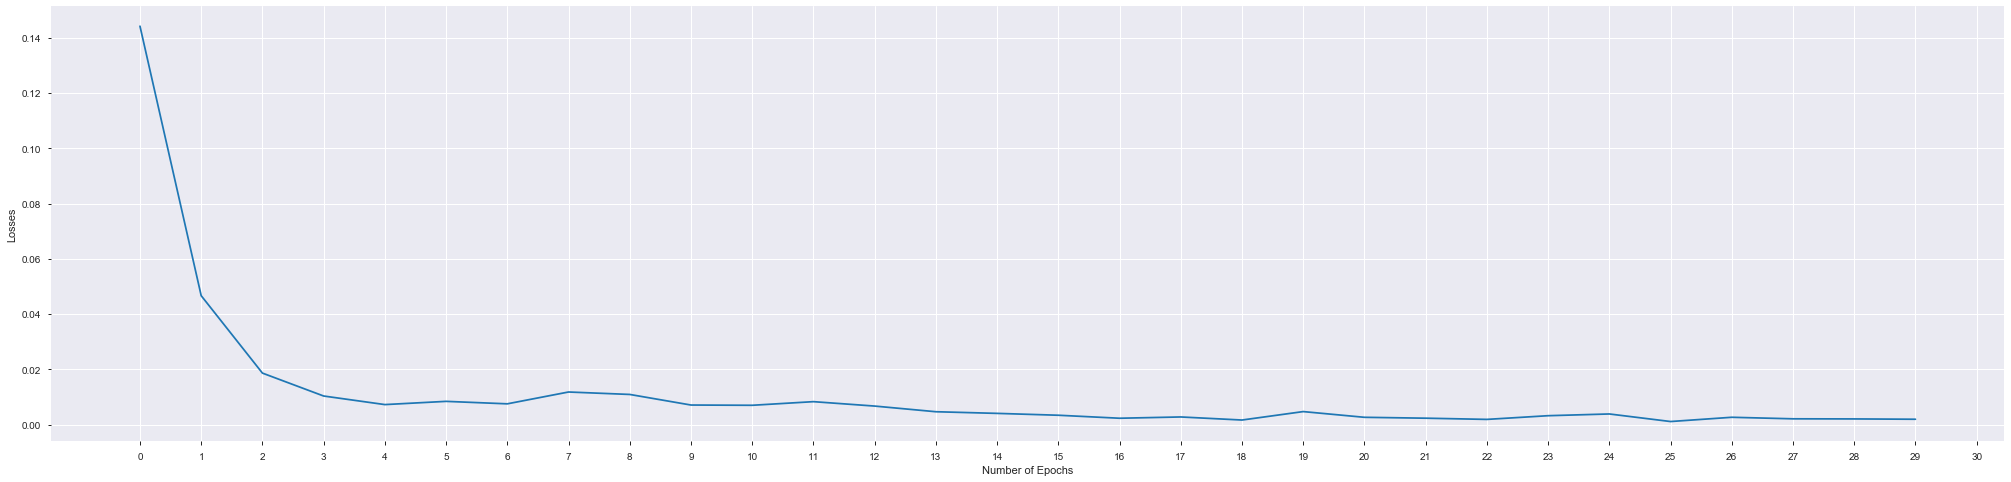

In [80]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(n_input,n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(generator, epochs=30)

losses = model.history.history['loss']
plt.figure(figsize = (35,8))
plt.xlabel('Number of Epochs')
plt.ylabel('Losses')
plt.xticks(np.arange(0,150,1))
plt.plot(range(len(losses)), losses)

In [81]:
prediction_scaled_Ina = []
batch = train_data[-n_input:]
current_batch = batch.reshape((1,n_input,n_features))
for i in range(len(test_data)):
    pred = model.predict(current_batch)[0]
    prediction_scaled_Ina.append(pred)
    current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)

In [82]:
prediction = pd.DataFrame(scaler.inverse_transform(prediction_scaled_Ina))

In [83]:
prediction

,0
0,2209.766520
1,2301.750108
2,2390.889061
3,2447.692162
4,2495.021808
5,2505.821000
6,2547.618936


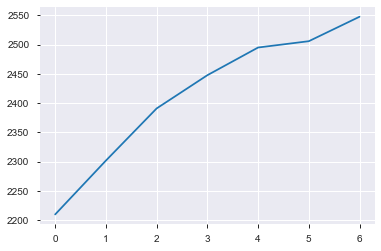

In [84]:
plt.plot(prediction)

Predicted how many people will be infected by the coronavirus in the next seven days at Indonesia